In [1]:
from tensorflow.python.keras.layers import Input, Dense, LSTM, Dropout, Convolution2D, MaxPooling2D, Activation, Flatten   

from tensorflow.python.keras.models import Sequential
import tensorflow as tf
from keras.utils import plot_model
from keras.optimizers import SGD, Adam
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
import datetime as dt
import pandas_datareader as pdr
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from ta import add_all_ta_features
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
register_matplotlib_converters()
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import bollinger_pband
import seaborn as sns
import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import sklearn.preprocessing as prep
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
from datetime import datetime
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
yf.pdr_override()

C:\Users\Parth\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Parth\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Parth\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [4]:
def get_exp_preprocessing(df):
    edata = df.ewm(alpha=0.9).mean()   
    return edata

In [31]:
def features(data, pct):
    data = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    
    #data = data[['momentum_rsi', 'Adj Close']]
    #data = data[['momentum_rsi']]
    #data = data[['Adj Close', 'momentum_wr', 'momentum_rsi','momentum_stoch', 'volatility_kcp', 'volatility_bbp', 'volatility_dcp']]
    data = data[[ 'momentum_rsi','volatility_bbp','Adj Close' ]]
    if pct == True:
        for col in data.columns:
            data[col] = data[col].pct_change()


        
    #data = data.dropna()
    cols = []
    for col in data.columns:
            cols.append(col)
            
    return data, cols

In [32]:
def split_x_y(data_final, close_vals):
    #train_scaled = data_final.dropna()
    #train_scaled = train_scaled.tail(train_scaled.shape[0] -1)
    #close_vals = close_vals.iloc[1:]
    Y = []
    X = []
    for i in range (0, len(data_final) - 3, 3):
        x_seq = data_final[i:i+3]
        if (close_vals[i+3] < close_vals[i+2] ):
            y_seq = 0
        else: 
            y_seq = 1
        X.append(x_seq)
        Y.append(y_seq)
    
    #X = X[1:]
    #Y = Y[1:]
    return X, Y

In [7]:
def split_train_test(train_scaled, Y):
    factor = 0.80

    length = train_scaled.shape[0]

    total_for_train = int(length*factor)

    X_train = np.array(train_scaled[:total_for_train])
    Y_train = np.array(Y[:total_for_train])
    X_test = np.array(train_scaled[total_for_train:])
    Y_test = np.array(Y[total_for_train:])
    
    return X_train, Y_train, X_test, Y_test

In [8]:
import keras 

def build_model(X_train, Y_train,X_test, Y_test):


    inputs = keras.Input(shape = (X_train.shape [1], X_train.shape [2]))
    x= keras.layers.LSTM(units = 100, return_sequences=True )(inputs)
    #x= keras.layers.Dropout(0.2)(x)
    x= keras.layers.LSTM(units = 100, return_sequences=True )(x)
   # x= keras.layers.Dropout(0.2)(x)
    x= keras.layers.LSTM(units = 100, return_sequences=False ) (x)
    #x= keras.layers.Dropout(0.2)(x)
    x=keras.layers.Dense(units = 32, activation = 'relu')(x)
    #x= keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(units = 1, activation = 'sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="Adam", loss="binary_crossentropy",  metrics = ['acc'])

    history = model.fit(X_train, Y_train, batch_size = 32, epochs = 100, validation_data=(X_test,Y_test), verbose=2)
    
    return model

In [9]:
## write optimal lr, Batch, Cells, 

In [22]:
up = 0 
down =0 
for x in Y_train:
    if x == 0:
        down += 1
    elif x == 1:
        up +=1

print("number of down: " + str(down))
print("number of up: " + str(up))

number of down: 571
number of up: 702


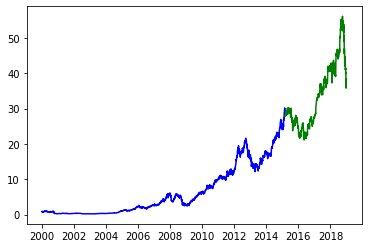

In [63]:
plt.plot(data_final["Adj Close"][0:len(X_train) * 3], label = "Adj Close", color='blue')
plt.plot(data_final["Adj Close"][len(X_train) * 3:len (data_final)], label = "Adj Close", color='green')

plt.show()

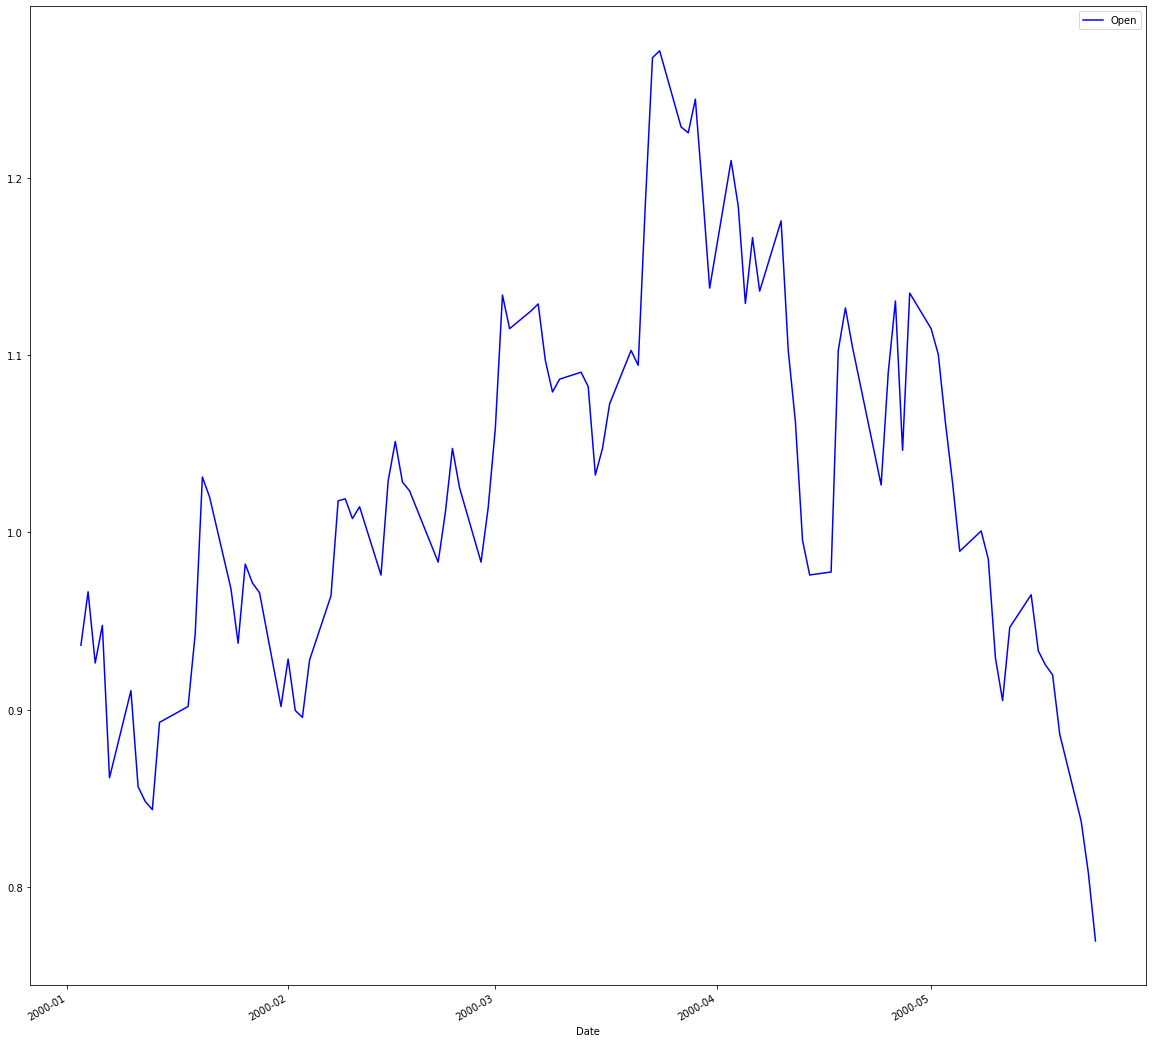

In [19]:
data.iloc[0:100,0:1].plot(subplots=True, color='blue', figsize=(20, 20));


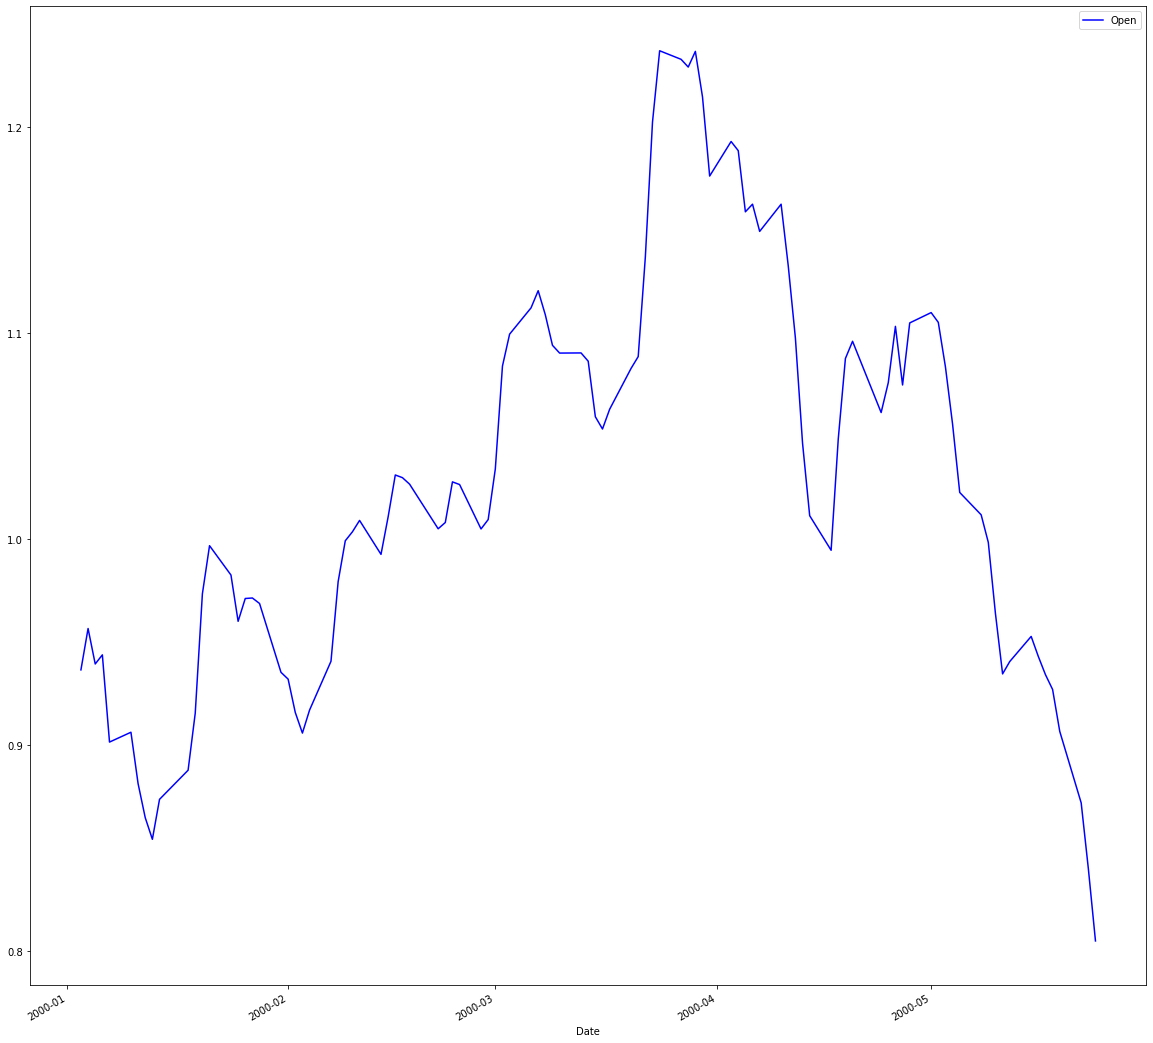

In [20]:
data_smoothed.iloc[0:100,0:1].plot(subplots=True, color='blue', figsize=(20, 20));


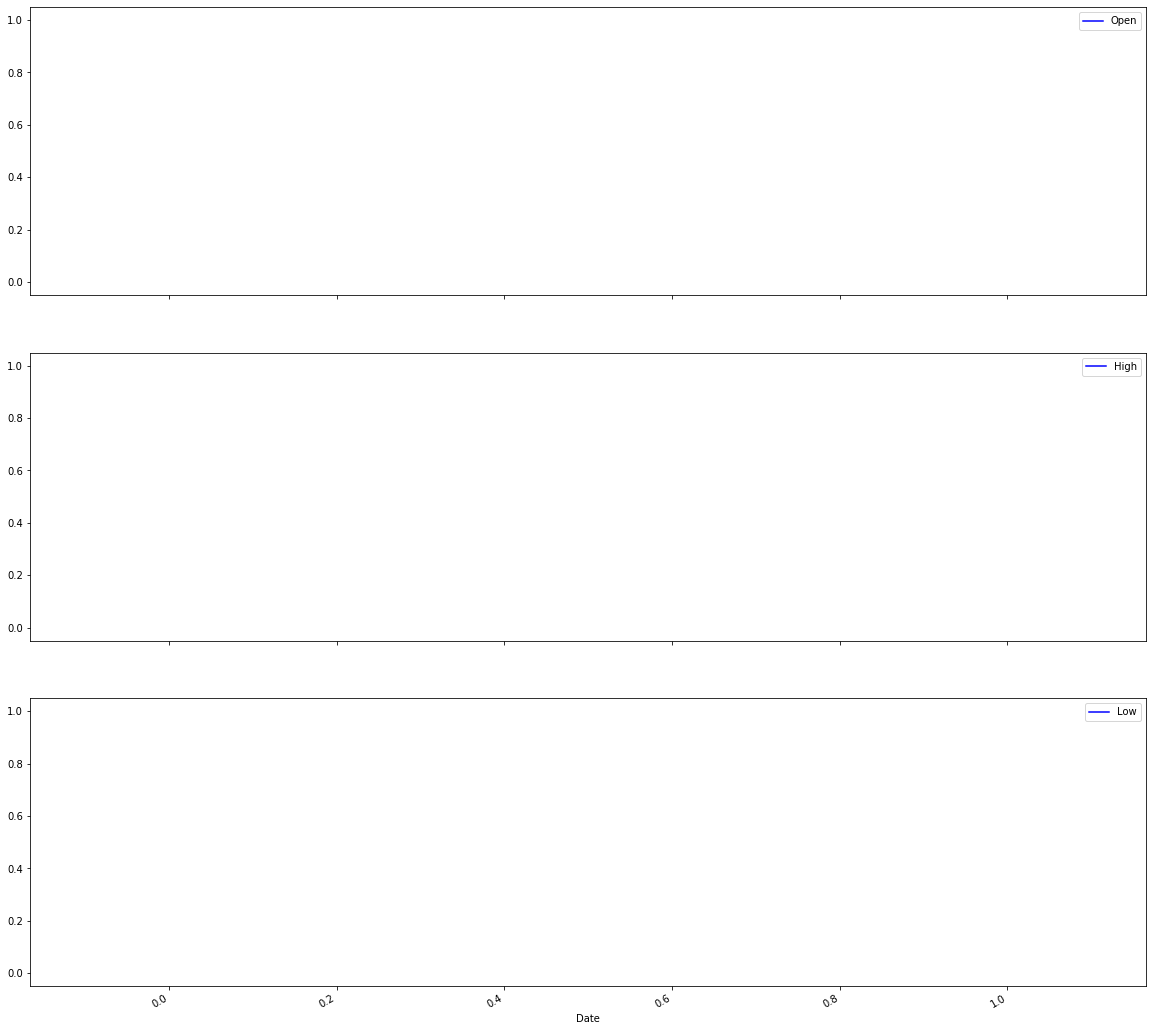

In [10]:
data_final.iloc[:,0:3].plot(subplots=True, color='blue', figsize=(20, 20));


In [84]:
X_dates = []
for i in range(data_smoothed.shape[0] // 3):
    X_dates.append(i)

In [129]:
Y = []
X = []
close = data_smoothed['Adj Close']
train_scaled = data_final['momentum_rsi']
for i in range (0, len(train_scaled) - 4, 4):
    x_seq = train_scaled[i:i+3]
    if (close[i+3] < close[i+2] ):
        y_seq = 0
    else: 
        y_seq = 1
    X.append(x_seq)
    Y.append(y_seq)

In [ ]:
y2= []
for a in X:
    avg = (a[0] + a[1] + a[2])  / 3 
    y2.append(avg)

In [130]:
y2 = np.array(y2)

In [ ]:
down_arr = []
down_dates = []
up_arr = []
up_dates = []
i=0
for result in Y:
    if result == 0:
        down_arr.append(y2[i])
        down_dates.append(X_dates[i])
    else:
        up_arr.append(y2[i])
        up_dates.append(X_dates[i])
    i += 1    

In [ ]:
small_down_dates = down_dates[0:25]
small_down_arr = down_arr[0:25]
small_up_dates = up_dates[0:25]
small_up_arr = up_arr[0:25]

In [ ]:
plt.scatter(small_down_dates,small_down_arr , color = 'red')
plt.scatter(small_up_dates, small_up_arr,color = 'green')
plt.show()

In [25]:
close

Date
2000-01-03     0.858137
2000-01-04     0.792365
2000-01-05     0.796798
2000-01-06     0.735135
2000-01-07     0.760024
2000-01-10     0.750438
2000-01-11     0.714981
2000-01-12     0.673057
2000-01-13     0.734841
2000-01-14     0.766462
2000-01-18     0.793773
2000-01-19     0.814615
2000-01-20     0.864566
2000-01-21     0.854468
2000-01-24     0.818529
2000-01-25     0.856333
2000-01-26     0.845882
2000-01-27     0.843544
2000-01-28     0.785526
2000-01-31     0.794386
2000-02-01     0.771123
2000-02-02     0.758878
2000-02-03     0.788702
2000-02-04     0.824027
2000-02-07     0.869388
2000-02-08     0.879530
2000-02-09     0.865020
2000-02-10     0.869606
2000-02-11     0.837292
2000-02-14     0.882788
2000-02-15     0.909331
2000-02-16     0.878349
2000-02-17     0.880426
2000-02-18     0.855623
2000-02-22     0.870822
2000-02-23     0.889160
2000-02-24     0.883771
2000-02-25     0.849920
2000-02-28     0.866371
2000-02-29     0.877504
2000-03-01     0.986853
2000-03-02 

In [12]:
data_final

,momentum_rsi,volatility_bbp,Adj Close
Date,,,
2000-01-03,100.000000,0.000000,0.858137
2000-01-04,0.000000,0.250000,0.792365
2000-01-05,6.768085,0.342009,0.796798
2000-01-06,3.360983,0.152674,0.735135
2000-01-07,20.710646,0.328311,0.760024
2000-01-10,19.275327,0.303821,0.750438
2000-01-11,15.105271,0.174245,0.714981
2000-01-12,11.842783,0.088016,0.673057
2000-01-13,34.347293,0.388639,0.734841


In [11]:
import sys
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)

In [13]:
X

array([[[ 3.36098287,  0.15267412,  0.73513518],
        [20.71064567,  0.32831126,  0.76002366],
        [19.27532745,  0.30382148,  0.75043802]],

       [[15.10527148,  0.17424538,  0.71498137],
        [11.84278336,  0.08801627,  0.67305673],
        [34.34729308,  0.38863923,  0.73484135]],

       [[42.44514245,  0.54297111,  0.76646223],
        [48.36861623,  0.67253584,  0.79377273],
        [52.39535964,  0.75821733,  0.8146154 ]],

       [[60.37180852,  0.93456046,  0.86456594],
        [58.24707976,  0.84412961,  0.8544682 ],
        [51.3237344 ,  0.67067376,  0.81852914]],

       [[57.10000067,  0.81718532,  0.85633256],
        [55.15169397,  0.75312514,  0.8458825 ],
        [54.70186523,  0.72976464,  0.84354407]],

       [[44.91440585,  0.46695989,  0.78552579],
        [46.48892943,  0.50810493,  0.79438551],
        [43.01250842,  0.41416516,  0.77112275]],

       [[41.26340102,  0.36255827,  0.75887809],
        [46.92478337,  0.51207566,  0.78870234],
        

In [14]:
Y

[0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,


In [34]:
X

array([[[  -0.50340715,   -0.55359654,   -0.0773888 ],
        [   5.16208011,    1.15040542,    0.03385565],
        [  -0.0693034 ,   -0.07459319,   -0.01261229]],

       [[  -0.21634164,   -0.42648761,   -0.04724794],
        [  -0.21598342,   -0.4948717 ,   -0.05863739],
        [   1.90027201,    3.4155383 ,    0.09179705]],

       [[   0.23576383,    0.39710834,    0.04303089],
        [   0.13955599,    0.23862177,    0.03563189],
        [   0.08325116,    0.12740063,    0.02625773]],

       [[   0.15223579,    0.23257597,    0.06131794],
        [  -0.03519406,   -0.09676298,   -0.01167954],
        [  -0.11886167,   -0.20548485,   -0.04206014]],

       [[   0.11254571,    0.21845429,    0.04618457],
        [  -0.03412096,   -0.07839125,   -0.01220328],
        [  -0.00815621,   -0.03101809,   -0.00276448]],

       [[  -0.17892369,   -0.36012261,   -0.06877919],
        [   0.03505609,    0.08811258,    0.01127871],
        [  -0.07477955,   -0.18488263,   -0.02928397]],

In [28]:
Y

[0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,


In [35]:
pct = True
start = datetime.strptime('2000-01-01', '%Y-%m-%d')
end = datetime.strptime('2019-1-01', '%Y-%m-%d')
data = pdr.get_data_yahoo("AAPL", start, end)

data_smoothed = get_exp_preprocessing(data)

data_final, cols = features(data_smoothed, pct)

# if pct == False:
#     scaler = MinMaxScaler()
#     data_final[data_final.columns] = scaler.fit_transform(data_final[data_final.columns])

close = data['Adj Close']

X, Y = split_x_y(data_final, close)


X = np.array(X)
    
X = X[1:]
Y = Y[1:]

X_train, Y_train, X_test, Y_test = split_train_test(X,Y)


model = build_model(X_train, Y_train, X_test, Y_test)


[*********************100%***********************]  1 of 1 completed
Train on 1272 samples, validate on 319 samples
Epoch 1/100
 - 1s - loss: 0.6928 - acc: 0.5220 - val_loss: 0.6911 - val_acc: 0.5361
Epoch 2/100
 - 0s - loss: 0.6923 - acc: 0.5244 - val_loss: 0.6908 - val_acc: 0.5266
Epoch 3/100
 - 0s - loss: 0.6919 - acc: 0.5283 - val_loss: 0.6894 - val_acc: 0.5361
Epoch 4/100
 - 0s - loss: 0.6919 - acc: 0.5267 - val_loss: 0.6893 - val_acc: 0.5392
Epoch 5/100
 - 0s - loss: 0.6912 - acc: 0.5236 - val_loss: 0.6896 - val_acc: 0.5361
Epoch 6/100
 - 0s - loss: 0.6918 - acc: 0.5291 - val_loss: 0.6894 - val_acc: 0.5455
Epoch 7/100
 - 0s - loss: 0.6911 - acc: 0.5252 - val_loss: 0.6893 - val_acc: 0.5329
Epoch 8/100
 - 0s - loss: 0.6910 - acc: 0.5236 - val_loss: 0.6891 - val_acc: 0.5392
Epoch 9/100
 - 0s - loss: 0.6915 - acc: 0.5244 - val_loss: 0.6894 - val_acc: 0.5392
Epoch 10/100
 - 0s - loss: 0.6901 - acc: 0.5244 - val_loss: 0.6890 - val_acc: 0.5298
Epoch 11/100
 - 0s - loss: 0.6916 - acc: 0.

 - 0s - loss: 0.6337 - acc: 0.6093 - val_loss: 0.7278 - val_acc: 0.5266
Epoch 97/100
 - 0s - loss: 0.6336 - acc: 0.5959 - val_loss: 0.7301 - val_acc: 0.5204
Epoch 98/100
 - 0s - loss: 0.6297 - acc: 0.6156 - val_loss: 0.7362 - val_acc: 0.5266
Epoch 99/100
 - 0s - loss: 0.6330 - acc: 0.6069 - val_loss: 0.7476 - val_acc: 0.5298
Epoch 100/100
 - 0s - loss: 0.6369 - acc: 0.5983 - val_loss: 0.7305 - val_acc: 0.5423


In [36]:
start = datetime.strptime('2019-01-01', '%Y-%m-%d')
end = datetime.strptime('2021-9-4', '%Y-%m-%d')

data = pdr.get_data_yahoo("AAPL", start, end)

data_smoothed = get_exp_preprocessing(data)

data_final, cols = features(data_smoothed, pct)

# scaler = MinMaxScaler()
# data_final[data_final.columns] = scaler.fit_transform(data_final[data_final.columns])   

close = data_smoothed['Adj Close']

X, Y = split_x_y(data_final, close)


X = np.array(X)

model.evaluate(X,Y)

#output = model.predict(X)

#print(np.round(output))


[*********************100%***********************]  1 of 1 completed
224/224 [==============================] - 0s 76us/step


[nan, 0.5]

In [163]:
start = datetime.strptime('2000-01-01', '%Y-%m-%d')
end = datetime.strptime('2019-01-01', '%Y-%m-%d')
data = pdr.get_data_yahoo("AAPL", start, end)

data = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
close = data_smoothed['Adj Close']

X, Y = split_x_y(data, close)

X = pd.DataFrame(X)
X['pred'] = Y

cor1 = X.corr()

correlations = cor1['pred']

print(correlations)

[*********************100%***********************]  1 of 1 completed


ValueError: Must pass 2-d input. shape=(1193, 3, 89)

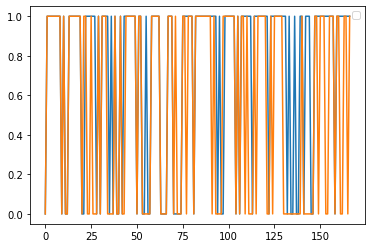

In [145]:
predicted = model.predict(X)
result = pd.DataFrame(predicted)
result.columns = [ '_predict']
result['_actual'] = Y

result = result.round()
result.plot()
plt.show()
 

In [159]:
start = datetime.strptime('2021-06-01', '%Y-%m-%d')
end = datetime.strptime('2021-09-12', '%Y-%m-%d')
data = pdr.get_data_yahoo("AAPL", start, end)
#data_smoothed = get_exp_preprocessing(data)
data_smoothed = data
#data_processed = preprocesses(data_smoothed)
data_final, cols = features(data_smoothed, pct)

data_final= data_final.tail(3)

close = data_smoothed['Adj Close']

XP, YP = split_x_y(data_final, close)


X = data_final.tail(3)
X = np.expand_dims(X, axis=0)


output = model.predict(X)


print(data_final.columns)
print(X.shape)


print(np.round(output))


[*********************100%***********************]  1 of 1 completed
Index(['momentum_rsi', 'volatility_bbp'], dtype='object')
(1, 3, 2)
[[0.]]


487
(487,)


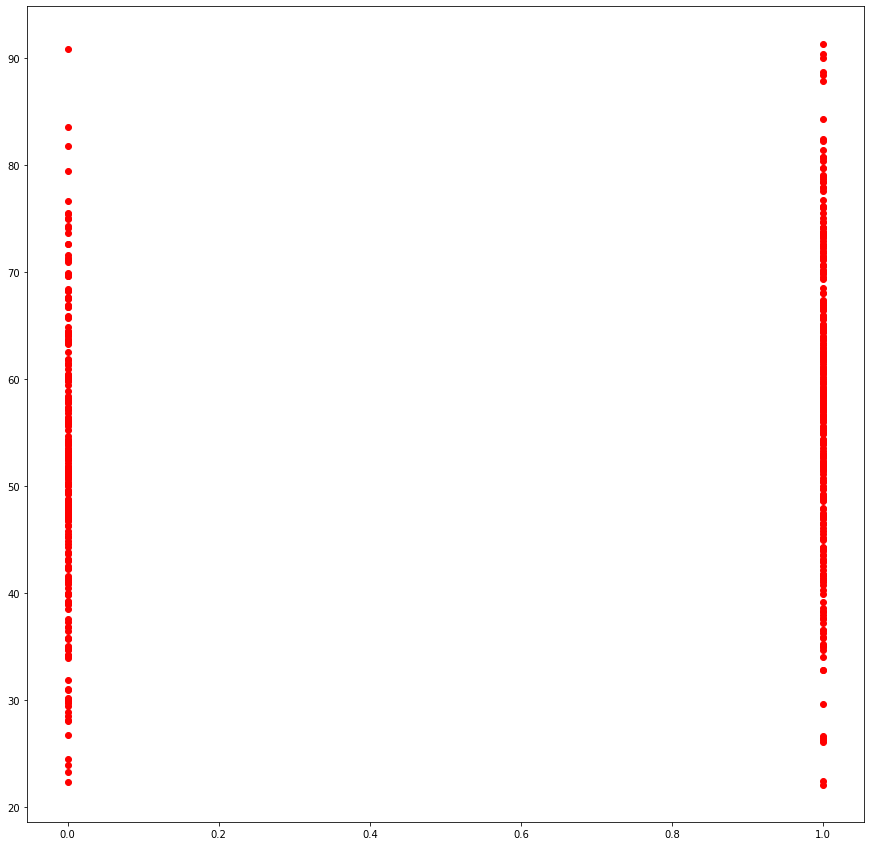

In [29]:
plt.figure(1, figsize=(15,15) )  
y = []
for x in X_test:
    avg = (x[0] + x[1] + x[2])  / 3 
    y.append(avg)

plt.scatter(Y_test,y, color = "red")    
plt.show()

In [37]:
acc = model.evaluate(X_test,Y_test)
y_pred=model.predict(X_test)
rounded = np.round(y_pred)
rounded = rounded.reshape(-1)

319/319 [==============================] - 0s 78us/step


inputs: ['momentum_rsi', 'volatility_bbp', 'Adj Close']
is data percent change: True
model loss & accuracy: [0.7304621768595657, 0.5423197746276855]


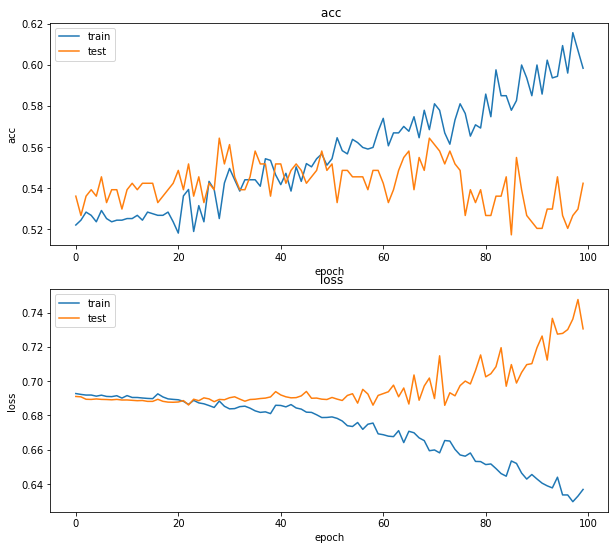

[Text(0, 0.5, 'Down'), Text(0, 1.5, 'Up')]

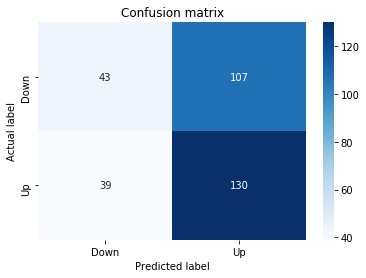

In [38]:

print ("inputs: " + str(cols)) 


print ("is data percent change: " + str(pct))

print ("model loss & accuracy: " + str(acc))

import matplotlib.pyplot as plt  
plt.figure(1, figsize=(10,9) )  

plt.subplot(211)  
plt.plot(model.history.history['acc'])  
plt.plot(model.history.history['val_acc'])  
plt.title(' acc')  
plt.ylabel('acc')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplot(212)  
plt.plot(model.history.history['loss'])  
plt.plot(model.history.history['val_loss'])  
plt.title(' loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

import sklearn.metrics as metrics
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(Y_test, rounded)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

In [31]:
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 1)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 3, 100)            40800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 100)            80400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________
